In [60]:
'''
Source: http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_1.html
If you get the error ImportError: cannot import name 'factorial':
    run `pip install statsmodels==0.10.0rc2 --pre` and restart the kernel.
'''
%matplotlib inline
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(12345)

In [72]:
# Add class to format printed strings (See: https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Generate some data from an ARMA process:

In [2]:
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])

The conventions of the arma_generate function require that we specify a 1 for the zero-lag of the AR and MA parameters and that the AR parameters be negated.

In [3]:
arparams = np.r_[1, -arparams]
maparams = np.r_[1, maparams]
nobs = 250 # number of observations
print('arparams:', arparams)
print('maparams:', maparams)
y = arma_generate_sample(arparams, maparams, nobs)

arparams: [ 1.   -0.75  0.25]
maparams: [1.   0.65 0.35]


Now, optionally, we can add some dates information. For this example, we'll use a pandas time series.

In [4]:
dates = sm.tsa.datetools.dates_from_range('1980m1', length=nobs)
y = pd.Series(y, index=dates)
arma_mod = sm.tsa.ARMA(y, order=(2,2))
arma_res = arma_mod.fit(trend='nc', disp=-1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [5]:
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  250
Model:                     ARMA(2, 2)   Log Likelihood                -353.445
Method:                       css-mle   S.D. of innovations              0.990
Date:                Wed, 19 Jun 2019   AIC                            716.891
Time:                        06:07:47   BIC                            734.498
Sample:                    01-31-1980   HQIC                           723.977
                         - 10-31-2000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.7904      0.134      5.878      0.000       0.527       1.054
ar.L2.y       -0.2314      0.113     -2.044      0.042      -0.453      -0.009
ma.L1.y        0.7007      0.127      5.525      0.0

In [6]:
y.tail()

2000-06-30    0.173211
2000-07-31   -0.048325
2000-08-31   -0.415804
2000-09-30    0.338725
2000-10-31    0.360838
dtype: float64

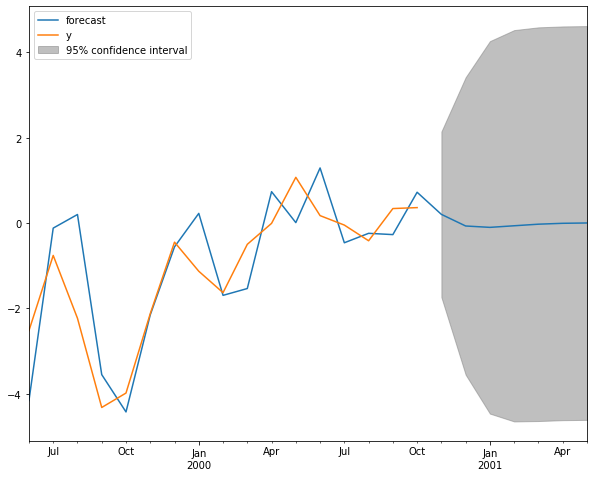

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
fig = arma_res.plot_predict(start='1999-06-30', end='2001-05-31', ax=ax) # end='2188-04-30' for nobs=2500
legend = ax.legend(loc='upper left')

## We now generate some data without statsmodels

In [31]:
# Source: https://www.statsmodels.org/stable/_modules/statsmodels/tsa/arima_process.html#arma_generate_sample
from scipy import signal
sigma = 1
distrvs = np.random.randn
nsample = 250 # number of observations/samples
burnin = 0
eta = sigma * distrvs(nsample + burnin) # this is where the random samples are drawn. Maybe we can insert our anomalies here?
y = signal.lfilter(maparams, arparams, eta)

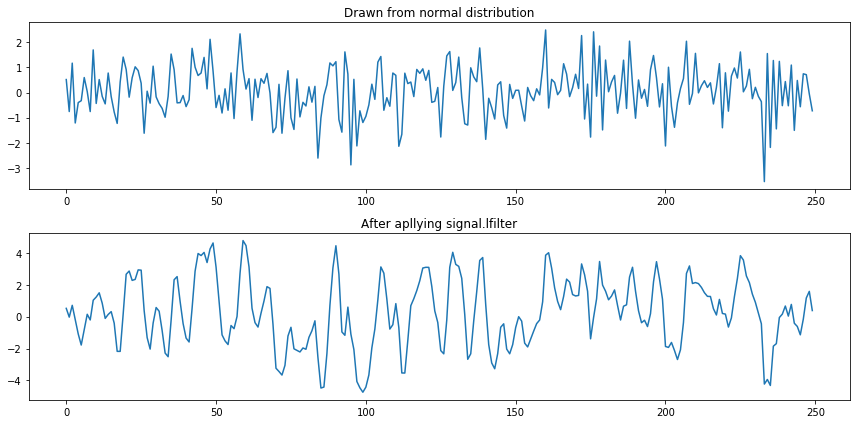

In [32]:
fig = plt.figure(1, figsize=(12, 6))
ax1 = fig.add_subplot(211)
ax1.title.set_text("Drawn from normal distribution")
ax1.plot(np.arange(nsample), eta)
ax2 = fig.add_subplot(212)
ax2.title.set_text("After apllying signal.lfilter")
ax2.plot(np.arange(nsample), y)
plt.tight_layout() # avoid overlapping plot titles

### is our generated data stationary?
First we look at the histograms

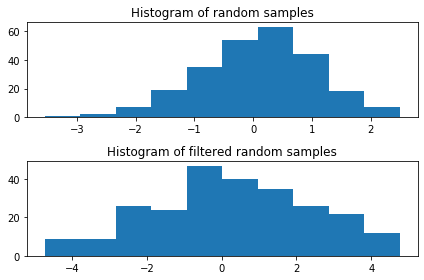

In [42]:
fig = plt.figure(1);
ax1 = fig.add_subplot(211)
ax1.title.set_text("Histogram of random samples")
ax1.hist(eta)
ax2 = fig.add_subplot(212)
ax2.title.set_text("Histogram of filtered random samples")
ax2.hist(y)
plt.tight_layout()

Then we check mean and variance

In [46]:
meanRaw, meanFiltered = eta.mean(), y.mean()
varRaw, varFiltered = eta.var(), y.var()
print('mean raw=%f, mean filtered=%f' % (meanRaw, meanFiltered))
print('variance raw=%f, variance filtered=%f' % (varRaw, varFiltered))

mean raw=0.067454, mean filtered=0.277438
variance raw=0.991535, variance filtered=4.464873


Augmented Dickey-Fuller test:<br>
**p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is **non-stationary**.<br>
**p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is **stationary**.<br>
*Source: [machinelearningmastery](https://machinelearningmastery.com/time-series-data-stationary-python/)*

In [71]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(data, name):
    result = adfuller(y)
    print('ADF Statistic: %f' % result[0])
    stationaryString = 'non-stationary' if result[1] > 0.05 else 'stationary'
    out = 'p-value: ' + color.BOLD + '%f' % result[1] + color.END
    out += ' and thus the data (' + name + ') is ' + color.BOLD + stationaryString + color.END
    print(out)
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

dickey_fuller(eta, 'raw')
dickey_fuller(y, 'filtered')

ADF Statistic: -6.383153
p-value: 0.000000 and thus the data (raw) is stationary
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic: -6.383153
p-value: 0.000000 and thus the data (filtered) is stationary
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


## Other experimental code 
First gerenate data from some model and then learn that model.

In [73]:
# Source: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.arma_generate_sample.html
import numpy as np
import statsmodels.api as sm
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 250)
model = sm.tsa.ARMA(y, (2, 2)).fit(trend='nc', disp=0)
model.params

array([ 0.79044192, -0.23140636,  0.70072906,  0.40608023])

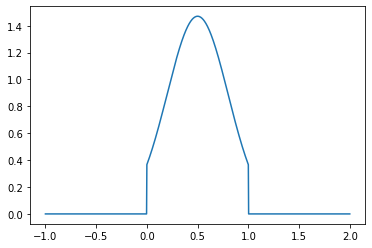

In [78]:
# See: https://stackoverflow.com/questions/41316068/truncated-normal-distribution-with-scipy-in-python
from scipy.stats import truncnorm
myclip_a = 0
myclip_b = 1
my_mean = 0.5
my_std = 0.3

a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
x_range = np.linspace(-1,2,1000)
plt.plot(x_range, truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std))